In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries

In [3]:
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Melspectrogram


In [4]:
def plot_melspectrogram(y,sr):
    melspec = librosa.feature.melspectrogram(y=y, sr=sr)
    melspec_db = librosa.power_to_db(melspec, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(melspec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Melspectrogram")
    plt.tight_layout()
    plt.show()

In [5]:
def plot_melspectrogram_chunks(y,sr):

    chunk_duration=4
    overlap_duration=2

    chunk_length=sr*chunk_duration
    overlap_length=sr*overlap_duration

    num_chunks=(len(y)-chunk_length)//(chunk_length-overlap_length)+1

    for i in range(num_chunks):
        start=i*(chunk_length-overlap_length)
        end=start+chunk_length
        chunk=y[start:end]

        melspec= librosa.feature.melspectrogram(y=chunk, sr=sr)
        melspec_db = librosa.power_to_db(melspec, ref=np.max)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(melspec_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Melspectrogram of Chunk {i+1}")
        plt.tight_layout()
        plt.show()

## Data Preprocessing


In [6]:
from tensorflow.image import resize

def preprocess_audio(dir, classes, target_size=(150, 150)):
    audio_data = []
    labels = []
    class_to_index = {cls: i for i, cls in enumerate(classes)}

    for label in classes:
        class_dir = os.path.join(dir, label)
        if not os.path.isdir(class_dir):
            continue

        for file_name in os.listdir(class_dir):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_dir, file_name)
                try:
                    y, sr = librosa.load(file_path, sr=None)
                except Exception as e:
                     continue

                chunk_duration = 4  # seconds
                overlap_duration = 2  # seconds

                chunk_length = int(sr * chunk_duration)
                overlap_length = int(sr * overlap_duration)

                if len(y) < chunk_length:
                    continue  # Skip short clips

                num_chunks = (len(y) - chunk_length) // (chunk_length - overlap_length) + 1

                for i in range(num_chunks):
                    start = i * (chunk_length - overlap_length)
                    end = start + chunk_length
                    chunk = y[start:end]

                    melspec = librosa.feature.melspectrogram(y=chunk, sr=sr)
                    melspec_db = librosa.power_to_db(melspec, ref=np.max)

                    # Resize and convert to NumPy
                    melspec_resized = tf.image.resize(
                        tf.expand_dims(melspec_db, axis=-1), target_size
                    ).numpy()

                    audio_data.append(melspec_resized)
                    labels.append(class_to_index[label])

    return np.array(audio_data), np.array(labels)

In [7]:
dir='/content/drive/MyDrive/audio_classify/Data/genres_original'
classes=os.listdir(dir)

In [8]:
audio_data,labels=preprocess_audio(dir, classes, target_size=(150, 150))

/tmp/ipython-input-6-2011877438.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [9]:
audio_data.shape, labels.shape

((13977, 150, 150, 1), (13977,))

In [10]:
from tensorflow.keras.utils import to_categorical
labels=to_categorical(labels, num_classes=len(classes))


## Splitting training and testing data


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(audio_data, labels, test_size=0.2, random_state=42)

In [12]:
X_train[0].shape

(150, 150, 1)

## Model Building


In [13]:
model=tf.keras.models.Sequential()

In [14]:
model.add(Conv2D(filters=32,kernel_size=3,padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [16]:
model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [17]:
model.add(Dropout(0.3))

In [18]:
model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [19]:
model.add(Conv2D(filters=512,kernel_size=3,padding='same', activation='relu'))
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [20]:
model.add(Dropout(0.3))

In [21]:
model.add(Flatten())

In [22]:
model.add(Dense(units=1200, activation='relu'))

In [23]:
model.add(Dropout(0.4))

## Output layer


In [24]:
model.add(Dense(units=len(classes), activation='softmax'))

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

## Compile model


In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [28]:
train_history=model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 60s 123ms/step - accuracy: 0.1282 - loss: 2.2445 - val_accuracy: 0.3022 - val_loss: 1.8698
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - accuracy: 0.3272 - loss: 1.7813 - val_accuracy: 0.5240 - val_loss: 1.2629
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.5262 - loss: 1.2671 - val_accuracy: 0.4653 - val_loss: 1.5435
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.6106 - loss: 1.0862 - val_accuracy: 0.5991 - val_loss: 1.1123
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.6851 - loss: 0.8845 - val_accuracy: 0.7489 - val_loss: 0.7369
Epoch 6/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.7495 - loss: 0.7214 - val_accuracy: 0.7661 - val_loss: 0.6992
Epoch 7/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.7770 - loss: 0.6341 - val_accuracy: 0.7775 - val_loss: 0.6681
Epoch 8/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.8232 - loss: 0.5033 -

## Saving model and training history

In [29]:
model.save("Trained_model.h5")

In [30]:
import json
with open('trainHistory.json', 'w') as f:
    json.dump(train_history.history, f)

## Model Evaluation


In [31]:
train_loss,train_accuracy=model.evaluate(X_train,y_train)

350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9916 - loss: 0.0306


In [32]:
train_loss,train_accuracy

(0.03381069004535675, 0.9900724291801453)

In [33]:
val_loss,val_accuracy=model.evaluate(X_test,y_test)

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9156 - loss: 0.2803


In [34]:
val_loss,val_accuracy

(0.27999815344810486, 0.9123747944831848)

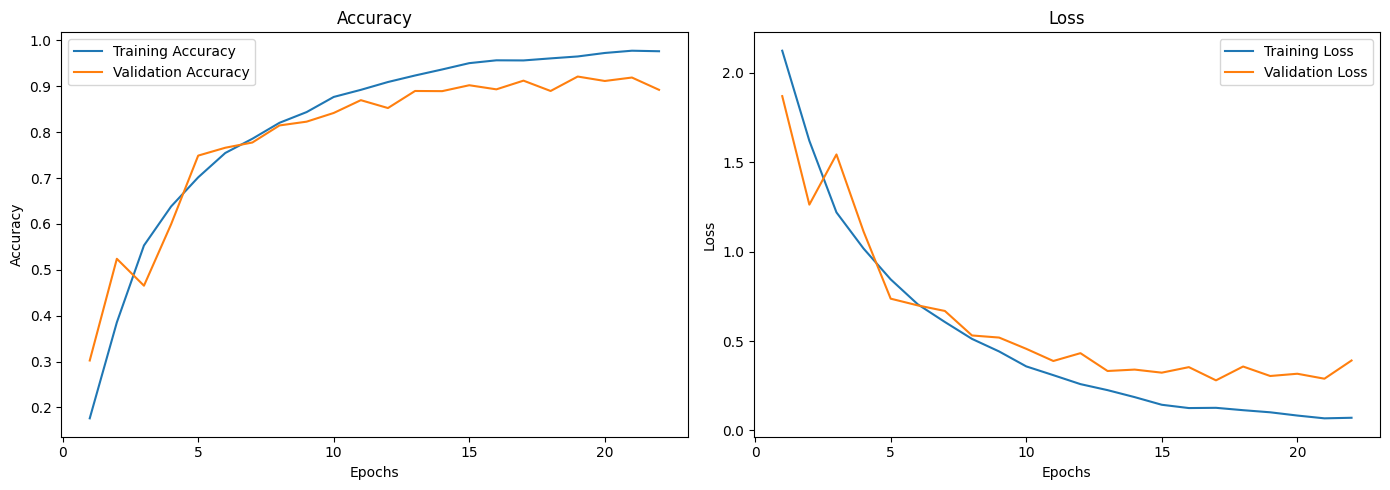

In [ ]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()




## Model Evaluation 2

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
cm=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), target_names=classes))

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
              precision    recall  f1-score   support

        jazz       0.86      0.95      0.91       286
      hiphop       0.98      0.86      0.92       274
      reggae       0.92      0.94      0.93       294
         pop       0.96      0.93      0.94       266
     country       0.94      0.82      0.88       293
        rock       0.78      0.85      0.81       271
   classical       0.95      0.96      0.95       289
       metal       0.92      0.96      0.94       296
       disco       0.90      0.92      0.91       257
       blues       0.95      0.94      0.95       270

    accuracy                           0.91      2796
   macro avg       0.92      0.91      0.91      2796
weighted avg       0.92      0.91      0.91      2796



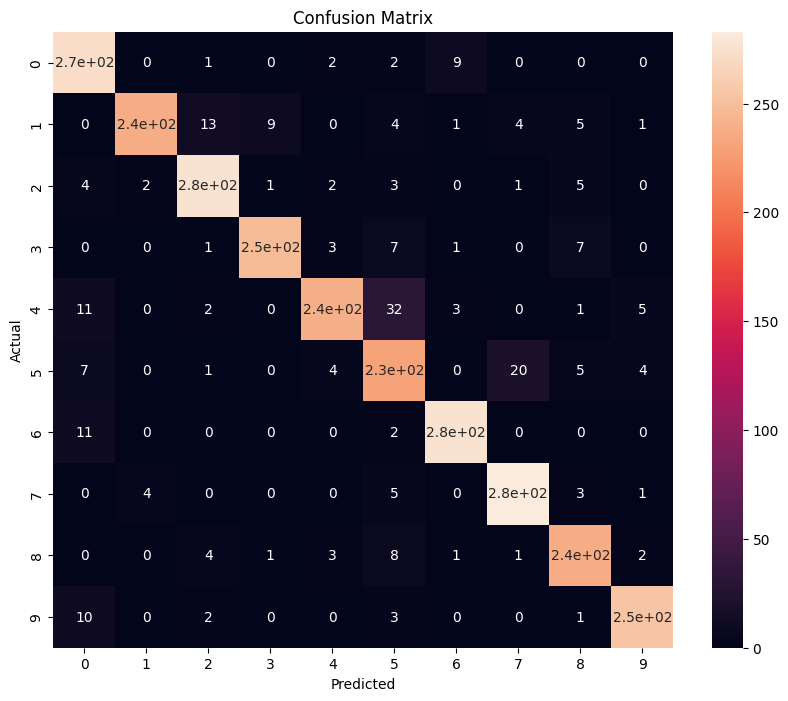

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True,annot_kws={"size":10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()